# Process
In this notebook, I will check whether other properties relate with popularity in the data.

# A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from split_users import split
from collections import Counter
from scipy import stats

# B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Preference
top_fraction_items = 0.2
split_popularity_by = "pop_fraq"
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_popularity_by=="pop_fraq") else "_sbpif")
addition_gender = addition_1 + "_tfu"+str(int(100*top_fraction_users))+  "_mfd"
addition_country = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_USAr"
addition_birthyear = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_1950r"

In [4]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [5]:
processed_file_location = "data/processed/" # here we store the processed data files

### Gender

In [6]:
low_mp = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")
med_mp = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")
high_mp = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_gender+".csv", index_col=0, header=0, low_memory=False).fillna("")


### Country

In [7]:
low_Up = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")
med_Up = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")
high_Up = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_country+".csv", index_col=0, header=0, low_memory=False).fillna("")


### Birthyear

In [8]:
low_1950p = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_birthyear+".csv", index_col=0, header=0, low_memory=False).fillna("")
med_1950p = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_birthyear+".csv", index_col=0, header=0, low_memory=False).fillna("")
high_1950p = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_birthyear+".csv", index_col=0, header=0, low_memory=False).fillna("")


### Popularity

In [9]:
df_item_dist= pd.read_csv(processed_file_location +recommendation_type + "/item_pop_dist"+addition_1+".csv", index_col=0)

In [10]:
low_popularity = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_4+".csv", index_col=0)
med_popularity = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_4+".csv", index_col=0)
high_popularity = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_4+".csv", index_col=0)

### Mapped ratings

In [11]:
mapped_ratings_with_properties = pd.read_csv(processed_file_location +recommendation_type + "/mapped_ratings_with_properties.csv", index_col=0)

In [12]:
mapped_ratings_with_properties

,User-ID,ISBN,Book-Rating,gender,country,birthyear
0,276847,0,8,unknown,unknown,unknown
1,276847,1,10,female,UK,1950-2000
2,276847,2,10,female,UK,1950-2000
3,276847,3,10,female,UK,1950-2000
4,276847,4,10,female,UK,1950-2000
...,...,...,...,...,...,...
88617,276688,6837,7,female,USA,1900-1950
88618,276688,1628,6,female,USA,1900-1950
88619,276688,4464,8,female,USA,1950-2000
88620,276688,5236,10,male,USA,1950-2000


In [13]:
gender_dict = {}
country_dict = {}
birthyear_dict = {}
for isbn in mapped_ratings_with_properties.ISBN.unique():
    gender_dict[isbn] = mapped_ratings_with_properties.gender[mapped_ratings_with_properties.ISBN == isbn].iloc[0]
    country_dict[isbn] = mapped_ratings_with_properties.country[mapped_ratings_with_properties.ISBN == isbn].iloc[0]
    birthyear_dict[isbn] = mapped_ratings_with_properties.birthyear[mapped_ratings_with_properties.ISBN == isbn].iloc[0]

# D. Compare properties with 'popular' items

In [14]:
df_item_dist["gender"] = ""
df_item_dist["country"] = ""
df_item_dist["birthyear"] = ""

for index, row in df_item_dist.iterrows():
    gender = gender_dict[index]
    country = country_dict[index]
    birthyear = birthyear_dict[index]
    df_item_dist.at[index, "gender"] = gender
    df_item_dist.at[index, "country"] = country
    df_item_dist.at[index, "birthyear"] = birthyear

In [15]:
num_pop_items = int(top_fraction_items * len(df_item_dist))


The items that are considered popular:

In [16]:
pop_item_dist = df_item_dist.iloc[:num_pop_items]

### D1. Gender

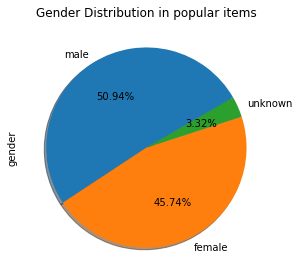

In [17]:
fig, ax = plt.subplots()
pop_item_dist.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular items")
fig.tight_layout()

In [36]:
pop_ratings = mapped_ratings_with_properties[mapped_ratings_with_properties.ISBN.isin(list(pop_item_dist.index))]

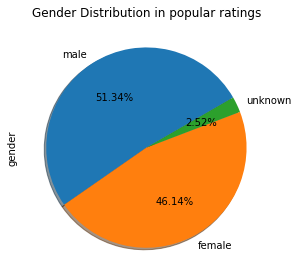

In [37]:
fig, ax = plt.subplots()
pop_ratings.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular ratings")
fig.tight_layout()

### D2. Country

In [41]:
colors={'USA':'#1f77b4', 
        'UK':'#d62728',
       "Ireland":"#8c564b",
       "unknown":"#ff7f0e",
       "Canada":"#9467bd",
       "other":"#2ca02c"}

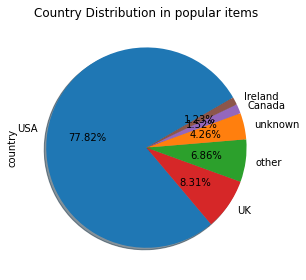

In [42]:
fig, ax = plt.subplots()
pop_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_item_dist['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in popular items")
fig.tight_layout()

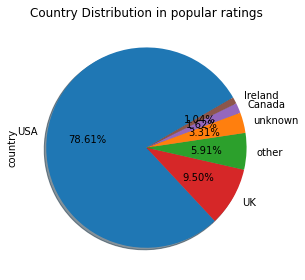

In [43]:
fig, ax = plt.subplots()
pop_ratings.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_ratings['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in popular ratings")
fig.tight_layout()

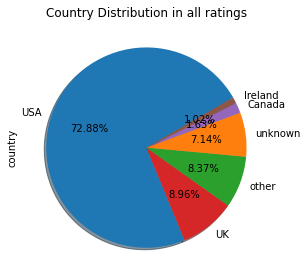

In [46]:
fig, ax = plt.subplots()
mapped_ratings_with_properties.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_ratings['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in all ratings")
fig.tight_layout()

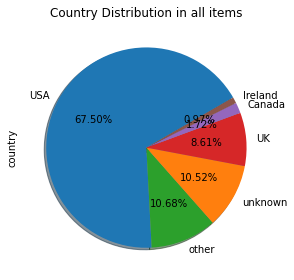

In [44]:
fig, ax = plt.subplots()
df_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in df_item_dist['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in all items")
fig.tight_layout()

In [39]:
df_item_dist.country.unique()

array(['USA', 'unknown', 'UK', 'other', 'Canada', 'Ireland'], dtype=object)

### D3. Birthyear

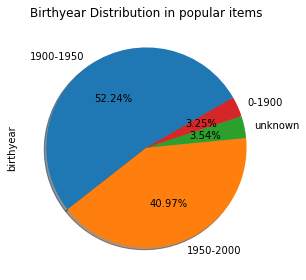

In [20]:
fig, ax = plt.subplots()
pop_item_dist.birthyear.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Birthyear Distribution in popular items")
fig.tight_layout()

# E. Compare properties with popularity for items

Point biserial correlation

### E.1 Gender

In [21]:
df_item_dist_test = df_item_dist.copy()

In [22]:
df_item_dist_test.gender = df_item_dist_test.gender.apply(lambda x: 1 if x == "male" else 0)

In [23]:
stats.pointbiserialr(df_item_dist_test.gender.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=0.02858858067481108, pvalue=0.017387322049614615)

### E.2 Country

In [24]:
df_item_dist_test = df_item_dist.copy()

In [25]:
df_item_dist_test.country = df_item_dist_test.country.apply(lambda x: 1 if x == "USA" else 0)

In [26]:
stats.pointbiserialr(df_item_dist_test.country.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=0.0935562786416678, pvalue=6.245466526952818e-15)

### E.3 Birthyear

In [27]:
df_item_dist_test = df_item_dist.copy()

In [28]:
df_item_dist_test.birthyear = df_item_dist_test.birthyear.apply(lambda x: 1 if x == "1900-1950" else 0)

In [29]:
stats.pointbiserialr(df_item_dist_test.birthyear.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=-0.01653306912509111, pvalue=0.16904660852433248)

### E.3 T test

In [40]:
df_non_unknowns = df_item_dist[df_item_dist.country!="unknown"]

#### E.3.a Gender

In [32]:
female_popularity = df_item_dist["count"][df_item_dist.gender == "female"].values
male_popularity = df_item_dist["count"][df_item_dist.gender == "male"].values

In [33]:
female_popularity.mean(), male_popularity.mean()

(0.0020779274065102996, 0.0020882984394199598)

In [34]:
stats.ttest_ind(female_popularity, male_popularity)

Ttest_indResult(statistic=-0.15934491198808048, pvalue=0.873402260673265)

#### E.3.b Country

In [41]:
USA_popularity = df_item_dist["count"][df_item_dist.country == "USA"].values
nonUSA_popularity = df_item_dist["count"][df_item_dist.country != "USA"].values

In [42]:
USA_popularity.mean(), nonUSA_popularity.mean()

(0.002174479783855462, 0.0016756250130251888)

In [43]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=7.816343057746824, pvalue=6.245466526884114e-15)

In [44]:
USA_popularity = df_non_unknowns["count"][df_non_unknowns.country == "USA"].values
nonUSA_popularity = df_non_unknowns["count"][df_non_unknowns.country != "USA"].values

In [45]:
USA_popularity.mean(), nonUSA_popularity.mean()

(0.002174479783855462, 0.0018308222992811094)

In [46]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=4.500952223525034, pvalue=6.888817733677745e-06)

#### E.3.c Birthyear

In [38]:
popularity_1950 = df_item_dist["count"][df_item_dist.birthyear == "1900-1950"].values
popularity_non1950 = df_item_dist["count"][df_item_dist.birthyear != "1900-1950"].values

In [39]:
popularity_1950.mean(), popularity_non1950.mean()

(0.0019716730789394515, 0.0020542590728199624)

In [40]:
stats.ttest_ind(popularity_1950, popularity_non1950)

Ttest_indResult(statistic=-1.3754173883722816, pvalue=0.16904660852205414)

# E. Compare properties with average popularity for users

In [40]:
full_gender_df = pd.concat([low_mp, med_mp, high_mp])
full_country_df = pd.concat([low_Up, med_Up, high_Up])
full_pop_df = pd.concat([low_popularity, med_popularity, high_popularity])

In [41]:
final_df = pd.merge(pd.merge(full_gender_df.male_female_difference, full_country_df.ratio_USA, left_index=True, right_index=True), full_pop_df, left_index=True, right_index=True)

In [42]:
final_df.head()

,male_female_difference,ratio_USA,count,pop_count,user_hist,pop_fraq,pop_item_fraq
258107,-1.0,0.666667,6,2,6,0.333333,0.002621
177876,-1.0,0.800000,5,2,5,0.400000,0.002737
178458,-1.0,0.800000,5,5,5,1.000000,0.004561
86170,-1.0,0.833333,6,1,6,0.166667,0.001494
179321,-1.0,0.600000,5,3,5,0.600000,0.007455


### E.1 Country

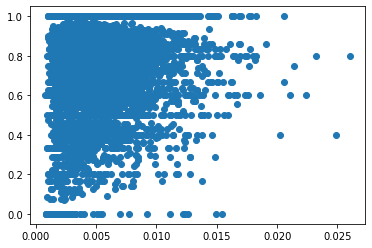

In [48]:
plt.scatter(final_df.pop_item_fraq.values, final_df.ratio_USA.values)

In [45]:
stats.pearsonr(final_df.pop_fraq.values, final_df.ratio_USA.values)[0]

0.17476558921723792

### E.2 Gender

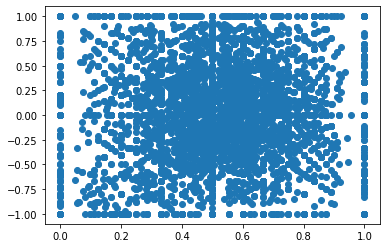

In [46]:
plt.scatter(final_df.pop_fraq.values, final_df.male_female_difference.values)

In [47]:
stats.pearsonr(final_df.pop_fraq.values, final_df.male_female_difference.values)[0]

0.014316413968774644

# F. Analyze properties for every popularity user group

In [152]:
low_popularity["male_female_difference"] = ""
low_popularity["ratio_USA"] = ""
med_popularity["male_female_difference"] = ""
med_popularity["ratio_USA"] = ""
high_popularity["male_female_difference"] = ""
high_popularity["ratio_USA"] = ""

In [153]:
for index, row in low_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    low_popularity.at[index, "male_female_difference"] = mfd
    low_popularity.at[index, "ratio_USA"] = rU

In [155]:
for index, row in med_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    med_popularity.at[index, "male_female_difference"] = mfd
    med_popularity.at[index, "ratio_USA"] = rU

In [154]:
for index, row in high_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    high_popularity.at[index, "male_female_difference"] = mfd
    high_popularity.at[index, "ratio_USA"] = rU

Let's see!

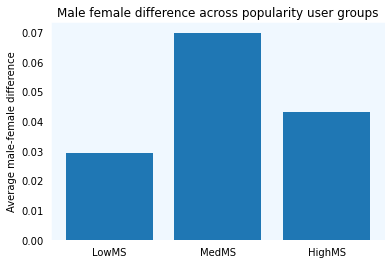

In [163]:
plt.figure()
ax = plt.axes()
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['left'].set_zorder(0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
ax.set_facecolor("aliceblue")
ylabel = 'Average male-female difference'
plt.ylabel(ylabel)
plt.bar(np.arange(3), [low_popularity.male_female_difference.mean(),med_popularity.male_female_difference.mean(),high_popularity.male_female_difference.mean()])
plt.title("Male female difference across popularity user groups")
plt.show()

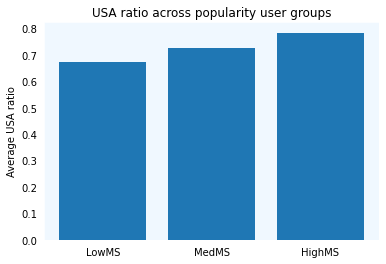

In [164]:
plt.figure()
ax = plt.axes()
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['left'].set_zorder(0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
ax.set_facecolor("aliceblue")
ylabel = 'Average USA ratio'
plt.ylabel(ylabel)
plt.bar(np.arange(3), [low_popularity.ratio_USA.mean(),med_popularity.ratio_USA.mean(),high_popularity.ratio_USA.mean()])
plt.title("USA ratio across popularity user groups")
plt.show()